In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip


In [26]:
#Can be done using one for loop
import zipfile

with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/train.zip") as z:
    z.extractall(".")
with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/train_masks.zip") as z:
    z.extractall(".")
with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip") as z:
    z.extractall(".")
    

In [27]:
import os
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import random
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image
# from torchvision.transforms import functional as F

In [28]:
len(os.listdir('/kaggle/working/train'))

5088

In [29]:
%config Completer.use_jedi = False

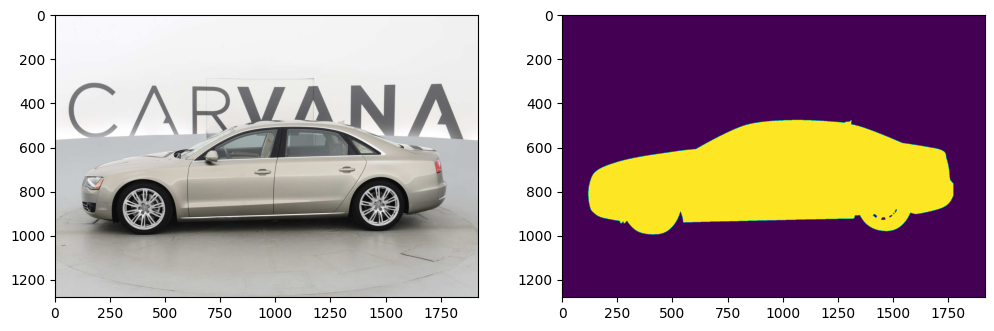

In [30]:
# for i in os.listdir('/kaggle/working/train'):
#very interesting thing. I always use random number fron numpy and use for loop. Use random.choice
i = random.choice(os.listdir('/kaggle/working/train'))
image = os.path.join('/kaggle/working/train',i)
im = cv2.imread(image)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
# plt.imshow(im)
file = i.replace('.jpg','_mask.gif')
mask = os.path.join('/kaggle/working/train_masks',file)
msk = Image.open(mask).convert('L')
# plt.imshow(msk)
fig,axes = plt.subplots(1,2,figsize=(12,6))
axes[0].imshow(im)
axes[1].imshow(msk)

    # print(i)
    # break

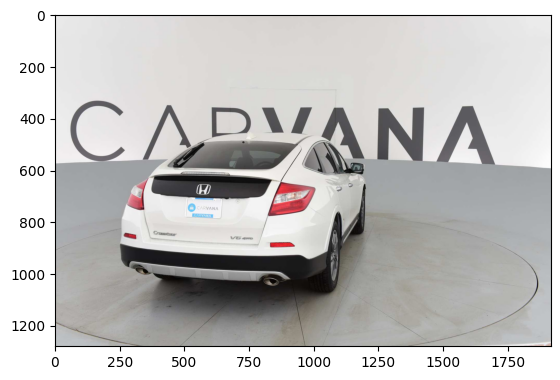

In [31]:
i = random.choice(os.listdir('/kaggle/working/train'))
image = os.path.join('/kaggle/working/train',i)
plt.imshow(np.array(Image.open(image).convert('RGB')))

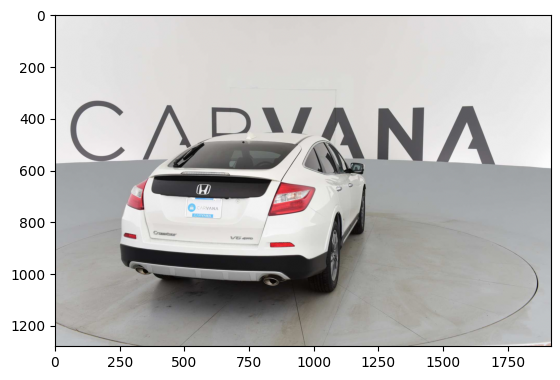

In [32]:
plt.imshow(np.array(Image.open(image).convert('RGB'))/255.0)

In [33]:
df = pd.read_csv('/kaggle/working/train_masks.csv')

In [34]:
df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


Next steps:
1. Dataset class
2. Create model
3. Train model

In [91]:
class CarvanaDataset(Dataset):
    def __init__(self,image_dir,mask_dir,transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(self.image_dir)

    def __len__(self):
        # return len(os.listdir(self.image_dir))
        return len(self.images)

    def __getitem__(self,idx):
        img_path = os.path.join(self.image_dir,self.images[idx])
        mask_path = os.path.join(self.mask_dir,self.images[idx].replace('.jpg','_mask.gif'))
        image = np.array(Image.open(img_path).convert('RGB'),dtype=np.float32)/255.0
        mask = np.array(Image.open(mask_path).convert('L'),dtype=np.float32)/255.0
        # mask = mask/255.0 #Normalize mask to 0 and 1
        mask = np.expand_dims(mask, axis=-1)

        if self.transform:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
            mask = mask.permute(2, 0, 1)
        else:
            image = torch.tensor(image,dtype = torch.float32).permute(2,0,1)
            mask = torch.tensor(mask,dtype = torch.float32).unsqueeze(0)
            
        return image,mask
        
        
    

In [92]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_func = A.Compose([A.Resize(256,256),
                       A.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                       ToTensorV2()])

In [93]:
transform_func

Compose([
  Resize(p=1.0, height=256, width=256, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [94]:
len(os.listdir('/kaggle/working/train'))

5088

In [39]:
os.chdir('/kaggle/working/')
list = ['train1_images','train1_masks','test1_images','test1_masks']
for i in list:
    os.makedirs(os.path.join('/kaggle/working/',i),exist_ok=True)


In [40]:
import shutil
k = 0
for i in (os.listdir('/kaggle/working/train')):
    if k < 4500:
        dest = (os.path.join('/kaggle/working/train',i))
        src = '/kaggle/working/train1_images'
        shutil.copy(dest,src)
        mask_dest = (os.path.join('/kaggle/working/train_masks',i.replace('.jpg','_mask.gif')))
        mask_src = '/kaggle/working/train1_masks'
        shutil.copy(mask_dest,mask_src)
    else:
        dest = (os.path.join('/kaggle/working/train',i))
        src = '/kaggle/working/test1_images'
        shutil.copy(dest,src)
        mask_dest = (os.path.join('/kaggle/working/train_masks',i.replace('.jpg','_mask.gif')))
        mask_src = '/kaggle/working/test1_masks'
        shutil.copy(mask_dest,mask_src)
    k+=1
        
    # break
    

In [95]:
image_dir='/kaggle/working/train'
mask_dir='/kaggle/working/train_masks'
train_data = CarvanaDataset(image_dir,mask_dir,transform=transform_func)

In [96]:
train_data[0][1].shape

torch.Size([1, 256, 256])

In [97]:
# fig,ax = plt.subplots(1,2,figsize=(12,6))
# # plt.imshow(train_data[1][1])
# ax[0].imshow(train_data[100][0])
# ax[1].imshow(train_data[100][1])


In [98]:
# image_dir='/kaggle/working/train'
# mask_dir='/kaggle/working/train_masks'
train_data = CarvanaDataset(image_dir='/kaggle/working/train1_images',mask_dir='/kaggle/working/train1_masks',transform=transform_func)
test_data = CarvanaDataset(image_dir='/kaggle/working/test1_images',mask_dir='/kaggle/working/test1_masks',transform=transform_func)

In [99]:
train_loader = DataLoader(train_data,batch_size=4,num_workers=1,shuffle=True)
test_loader = DataLoader(test_data,batch_size=4,num_workers=1,shuffle=False)

In [100]:
train_data[0][1].shape

torch.Size([1, 256, 256])

Model

In [85]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        self.encoder1 = DoubleConv(in_channels, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = DoubleConv(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)
    

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [86]:
model = UNet().to(device)

In [87]:
sample_input = torch.randn(1, 3, 256, 256)  # Batch size of 1, 3 channels, 256x256 image
output = model(sample_input.to(device))
print(output.shape)  # Output shape should be [1, 1, 256, 256]


torch.Size([1, 1, 256, 256])


In [88]:
#Hyperparam
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-04)

In [ ]:
from tqdm import tqdm

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.to(device)  # Move to GPU if available
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        # outputs=outputs.squeeze(0)
        loss = loss_fn(outputs, masks)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}")
    
    # Scheduler step (optional)
    # scheduler.step(train_loss)


100%|██████████| 1125/1125 [04:29<00:00,  4.18it/s]


Epoch [1/50], Loss: 0.0813


100%|██████████| 1125/1125 [04:29<00:00,  4.17it/s]


Epoch [2/50], Loss: 0.0226


100%|██████████| 1125/1125 [04:30<00:00,  4.17it/s]


Epoch [3/50], Loss: 0.0125


100%|██████████| 1125/1125 [04:30<00:00,  4.17it/s]


Epoch [4/50], Loss: 0.0116


100%|██████████| 1125/1125 [04:30<00:00,  4.16it/s]


Epoch [5/50], Loss: 0.0092


100%|██████████| 1125/1125 [04:29<00:00,  4.17it/s]


Epoch [6/50], Loss: 0.0089


100%|██████████| 1125/1125 [04:30<00:00,  4.16it/s]


Epoch [7/50], Loss: 0.0071


100%|██████████| 1125/1125 [04:30<00:00,  4.16it/s]


Epoch [8/50], Loss: 0.0066


100%|██████████| 1125/1125 [04:30<00:00,  4.16it/s]


Epoch [9/50], Loss: 0.0073


100%|██████████| 1125/1125 [04:30<00:00,  4.16it/s]


Epoch [10/50], Loss: 0.0060


100%|██████████| 1125/1125 [04:30<00:00,  4.16it/s]


Epoch [11/50], Loss: 0.0056


100%|██████████| 1125/1125 [04:30<00:00,  4.16it/s]


Epoch [12/50], Loss: 0.0076


100%|██████████| 1125/1125 [04:30<00:00,  4.16it/s]


Epoch [13/50], Loss: 0.0055


 89%|████████▉ | 1002/1125 [04:00<00:29,  4.16it/s]

In [ ]:
torch.save(model.state_dict(), 'carvana_unet_model.pth')

In [ ]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True